In [36]:
import sys
sys.path.append('../shap')
import shap

import os
sys.path.append('../..')
sys.path.append('../../utils/')
import numpy as np
import deepbayesHF
import deepbayesHF.optimizers as optimizers
from deepbayesHF import PosteriorModel
from deepbayesHF.analyzers import FGSM
from deepbayesHF.analyzers import eps_LRP
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import cv2
import random
import matplotlib.pyplot as plt
from collections import namedtuple

from joblib import Parallel, delayed
import subprocess
from statistics import mode
import json
import tensorflow as tf
import imageio

from load_data import load_data
import scipy

In [27]:
def print_exp(exp,text,ax=None):   
    xs = []
    ys = []
    for i in range(int(len(exp)/5)):
        total = np.sum(exp[(i*5):(i*5)+5])
        txt = text[i] if i < len(text) else '<PAD>'
        xs.append(txt)
        ys.append(total)
        
    objects = xs[::-1]
    y_pos = np.arange(len(objects))
    performance = ys[::-1]

    if ax == None:
        plt.barh(y_pos, performance, align='center', alpha=0.5)
        plt.yticks(y_pos, objects)
        plt.xlabel('Weight')
        plt.title('Word')

        plt.show()
    else:
        ax.barh(y_pos, performance, align='center', alpha=0.5)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(objects)
        ax.set_xlabel('Weight')
        ax.set_title('Word')

In [3]:
maxlen = 10
emb_dims = 5
X_train, y_train, X_test, y_test, text_train, text_test = load_data('SST',maxlen,emb_dims,'../../training_data/','../../embeddings/',True)

In [4]:
model_name = f'SST_SHAP'

opt = optimizers.VariationalOnlineGuassNewton()
likelihood = tf.keras.losses.SparseCategoricalCrossentropy()
model = Sequential()
model.add(Dense(32,activation='relu',input_shape=X_train[0].shape))
model.add(Dense(16,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(2,activation='softmax'))

bayes_model = opt.compile(model,loss_fn=likelihood,
                          epochs=25, learning_rate=0.25,
                          inflate_prior=2.0, log_file='tmp/log.txt')
bayes_model.train(X_train,y_train,X_test,y_test)
bayes_model.save(model_name)

This optimizer does not have a default compilation method. Please make sure to call the correct .compile method before use.
deepbayes: Using implicit prior
(50, 32) 0.2
(32, 16) 0.25
(16, 8) 0.3535533905932738
(8, 2) 0.5
deepbayes: Using implicit prior
(50, 32) 0.2
(32, 16) 0.25
(16, 8) 0.3535533905932738
(8, 2) 0.5


  0%|          | 9/1832 [00:00<00:21, 84.60it/s]

Epoch 1, loss: 0.549, acc: 0.691, val_loss: 1.042, val_acc: 0.742


  0%|          | 9/1832 [00:00<00:21, 86.79it/s]

Epoch 2, loss: 0.397, acc: 0.836, val_loss: 0.671, val_acc: 0.744


  1%|          | 10/1832 [00:00<00:19, 92.88it/s]

Epoch 3, loss: 0.336, acc: 0.862, val_loss: 0.521, val_acc: 0.788


  0%|          | 9/1832 [00:00<00:20, 88.81it/s]

Epoch 4, loss: 0.318, acc: 0.870, val_loss: 0.545, val_acc: 0.786


  0%|          | 9/1832 [00:00<00:20, 88.98it/s]

Epoch 5, loss: 0.302, acc: 0.876, val_loss: 0.527, val_acc: 0.793


  1%|          | 10/1832 [00:00<00:19, 92.63it/s]

Epoch 6, loss: 0.306, acc: 0.873, val_loss: 0.488, val_acc: 0.798


  1%|          | 10/1832 [00:00<00:18, 98.12it/s]

Epoch 7, loss: 0.307, acc: 0.870, val_loss: 0.541, val_acc: 0.786


  1%|          | 10/1832 [00:00<00:19, 93.40it/s]

Epoch 8, loss: 0.296, acc: 0.877, val_loss: 0.517, val_acc: 0.791


  0%|          | 9/1832 [00:00<00:20, 89.88it/s]

Epoch 9, loss: 0.298, acc: 0.877, val_loss: 0.538, val_acc: 0.786


  1%|          | 10/1832 [00:00<00:19, 95.77it/s]

Epoch 10, loss: 0.294, acc: 0.878, val_loss: 0.529, val_acc: 0.786


  1%|          | 10/1832 [00:00<00:19, 94.68it/s]

Epoch 11, loss: 0.296, acc: 0.877, val_loss: 0.520, val_acc: 0.788


  1%|          | 10/1832 [00:00<00:19, 92.10it/s]

Epoch 12, loss: 0.294, acc: 0.876, val_loss: 0.520, val_acc: 0.786


  0%|          | 9/1832 [00:00<00:20, 89.44it/s]

Epoch 13, loss: 0.295, acc: 0.875, val_loss: 0.484, val_acc: 0.796


  1%|          | 10/1832 [00:00<00:19, 93.39it/s]

Epoch 14, loss: 0.301, acc: 0.876, val_loss: 0.456, val_acc: 0.809


  1%|          | 10/1832 [00:00<00:19, 92.09it/s]

Epoch 15, loss: 0.309, acc: 0.871, val_loss: 0.445, val_acc: 0.801


  1%|          | 11/1832 [00:00<00:17, 101.54it/s]

Epoch 16, loss: 0.305, acc: 0.873, val_loss: 0.452, val_acc: 0.808


  0%|          | 9/1832 [00:00<00:20, 89.63it/s]

Epoch 17, loss: 0.296, acc: 0.877, val_loss: 0.473, val_acc: 0.799


  1%|          | 10/1832 [00:00<00:19, 93.60it/s]

Epoch 18, loss: 0.291, acc: 0.880, val_loss: 0.461, val_acc: 0.799


  1%|          | 10/1832 [00:00<00:19, 93.04it/s]

Epoch 19, loss: 0.289, acc: 0.879, val_loss: 0.459, val_acc: 0.804


  1%|          | 10/1832 [00:00<00:18, 98.26it/s]

Epoch 20, loss: 0.291, acc: 0.879, val_loss: 0.460, val_acc: 0.802


  1%|          | 10/1832 [00:00<00:19, 93.37it/s]

Epoch 21, loss: 0.288, acc: 0.880, val_loss: 0.470, val_acc: 0.801


  0%|          | 9/1832 [00:00<00:20, 89.10it/s]

Epoch 22, loss: 0.286, acc: 0.881, val_loss: 0.469, val_acc: 0.800


  1%|          | 10/1832 [00:00<00:19, 94.80it/s]

Epoch 23, loss: 0.285, acc: 0.881, val_loss: 0.466, val_acc: 0.802


  0%|          | 8/1832 [00:00<00:24, 73.37it/s]

Epoch 24, loss: 0.285, acc: 0.881, val_loss: 0.465, val_acc: 0.802


  1%|          | 10/1832 [00:00<00:19, 93.84it/s]

Epoch 25, loss: 0.285, acc: 0.881, val_loss: 0.468, val_acc: 0.801


100%|██████████| 1832/1832 [00:17<00:00, 103.59it/s]

Epoch 26, loss: 0.284, acc: 0.881, val_loss: 0.468, val_acc: 0.802
('batch_size', 64)
('learning_rate', 0.25)
('decay', 0.0)
('epochs', 26)
('inflate_prior', 2.0)
('input_noise', 0.0)
('robust_train', 0)
('epsilon', 0.1)
('robust_lambda', 0.5)
('loss_monte_carlo', 2)
('input_upper', inf)
('input_lower', -inf)
('beta_1', 0.999)
('beta_2', 0.9999)
('lam', 1.0)
('N', 117219)
('max_eps', 0.1)
('max_robust_lambda', 0.5)


In [5]:
model_name = f'SST_SHAP'
bayes_model = PosteriorModel(model_name)
y_pred = bayes_model.predict(X_test[:50],n=50)
check_accuracy = tf.keras.metrics.Accuracy(name="train_acc")
check_accuracy(y_test[:50],np.argmax(y_pred,axis=1))
print()
print('Loaded model accuracy:',f'{check_accuracy.result().numpy()*100:.2f}%')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                1632      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 18        
Total params: 2,314
Trainable params: 2,314
Non-trainable params: 0
_________________________________________________________________
deepbayes: detected the above model 
 None

Loaded model accuracy: 80.00%


In [11]:
N = 50
n = 0
while True:
    n = np.random.choice(list(range(len(X_train))))
    if y_train[n] == 0:
        break


print(n)
        
print(X_train[n].shape)
X = X_train[n].reshape(1,*X_train[n].shape)
y_hat = np.argmax(bayes_model.predict(X,n=N))
y_class = 'Positive.' if y_hat == 1 else 'Negative.'
y_true_text = 'Positive.' if y_train[n] == 1 else 'Negative.'
print(text_train[n])
print('Prediction:',y_class,'Ground truth:',y_true_text)
input_shape = X.flatten().shape

105576
(50,)
['think', 'its', 'a', 'tougher', 'picture', 'than', 'it', 'is']
Prediction: Negative. Ground truth: Negative.


In [62]:
#background = X_train[np.random.choice(X_train.shape[0],100,replace=False)]
#bayes_model.set_weights(bayes_model.sample())
#model = bayes_model.model
#e = shap.DeepExplainer(model,background)
#shap_values = e.shap_values(X)

In [63]:
#print(X.shape)
#print(shap_values[0].shape)
#shap.image_plot(shap_values,-X)

In [12]:
background = X_train[np.random.choice(X_train.shape[0],200,replace=False)]

if not os.path.exists(f'exps/exp{n}'):
    os.mkdir(f'exps/exp{n}')
    
input_path = f'exps/exp{n}/X.npy'
background_path = f'exps/exp{n}/bg.npy'
y_path = f'exps/exp{n}/y.npy'
np.save(y_path,y_hat,False)
np.save(input_path,X,False)
np.save(background_path,background,False)

iterations = 10
for i in range(iterations):
    subprocess.Popen(['python3','get_SHAP_exp.py',str(i),model_name,input_path,f'exps/exp{n}',background_path])
        
full = False 
while not full:
    if len([name for name in os.listdir(f'exps/exp{n}') if os.path.isfile(os.path.join(f'exps/exp{n}', name))]) == iterations+2:
        full = True
        

## Display All Explanations From Sampled BNNs

Input: ['think', 'its', 'a', 'tougher', 'picture', 'than', 'it', 'is']
Class: 0
Experiment #0


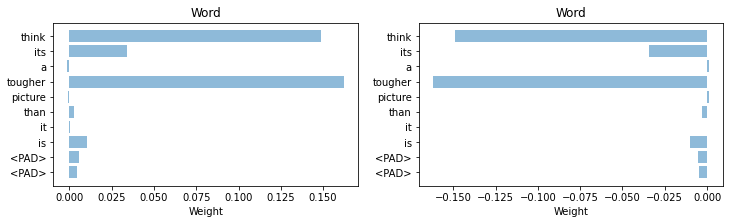

Experiment #1


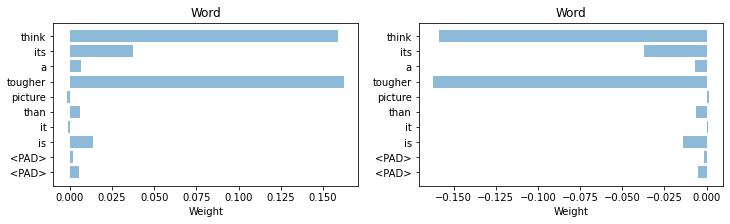

Experiment #2


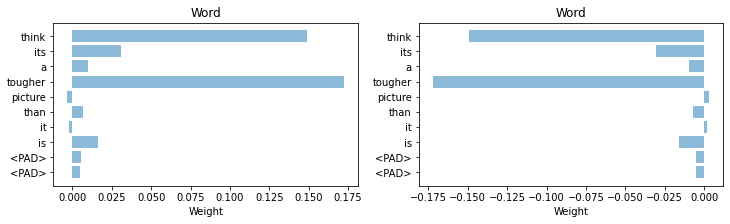

Experiment #3


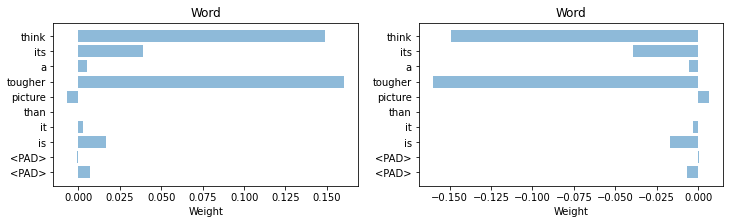

Experiment #4


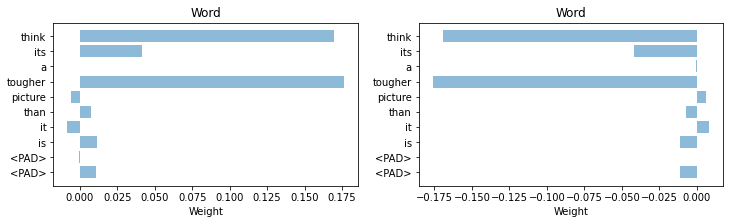

Experiment #5


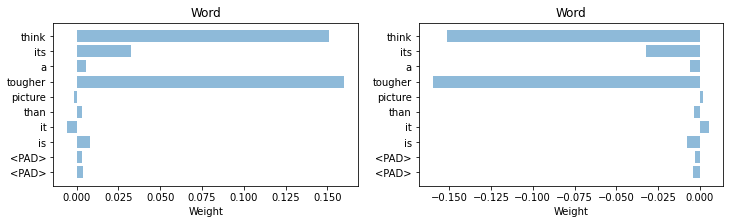

Experiment #6


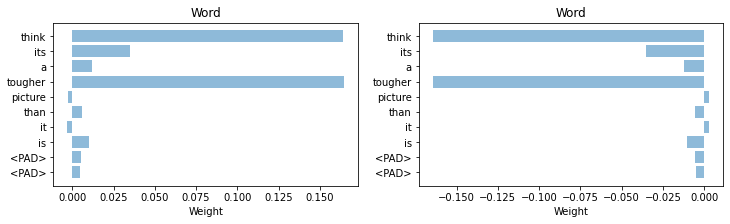

Experiment #7


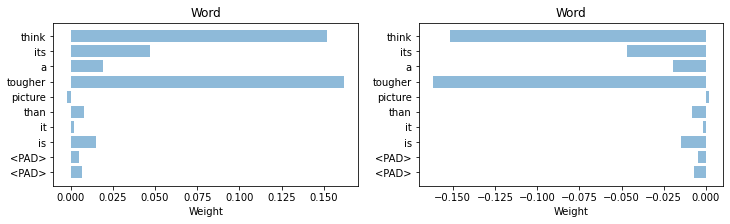

Experiment #8


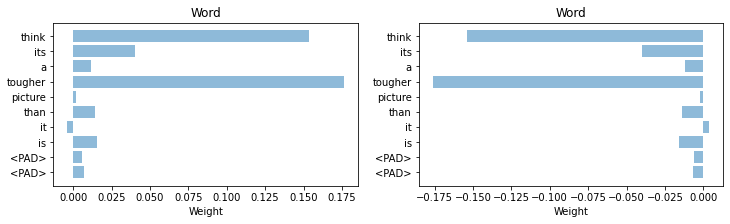

Experiment #9


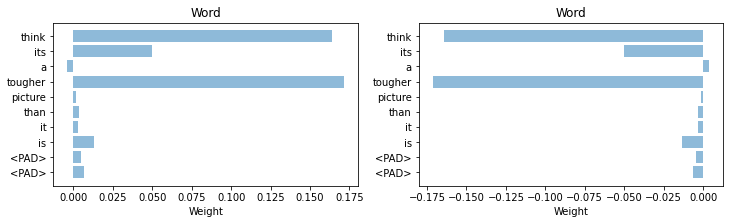


------------------------------------------------------------------



In [34]:
idxs = [105576]
# 1 positive 0 negative
y_trues = [0]

for ii in range(len(idxs)):
    idx = idxs[ii]
    y_true = y_trues[ii]

    input_path = 'X_tmp.npy'
    output_path = f'exps/exp{idx}'
    y_path = 'y_tmp.npy'


    exps = []
    for f in os.listdir(output_path):
        if os.path.isfile(os.path.join(output_path,f)) and not f.startswith('X') and not f.startswith('y') and not f.startswith('bg'):
            tmp = np.load(os.path.join(output_path,f))
            exps.append(tmp)

    sentence = text_train[idx]
    print('Input:',sentence)
    print('Class:',y_true)
    for jj,exs in enumerate(exps):
        print('Experiment #'+str(jj))
        fig, axs = plt.subplots(1,2)
        fig.set_size_inches(12,3)
        for i in range(2):
            ex = exs[i].reshape(50)
            print_exp(ex,text_train[idx],axs[i])
        plt.show()
            
    print()
    print('------------------------------------------------------------------')
    print()

In [51]:
N = 50

while True:
    # pick a random input
    n = np.random.choice(list(range(len(X_train))))
    X = X_train[n].reshape(1,*X_train[n].shape)
    ys = []
    for i in range(N):
        bayes_model.model.set_weights(bayes_model.sample())
        ys.append(bayes_model.model(X))
    ys = np.argmax(np.array(ys),axis=2).flatten()
    md = scipy.stats.mode(ys)[0]
    y_hat = md[0]
    y_class = 'Positive.' if y_hat == 1 else 'Negative.'
    y_true_text = 'Positive.' if y_train[n] == 1 else 'Negative.'
    input_shape = X.flatten().shape
    ys = list(ys)
    if ys.count(md) < int(len(ys)*0.75):
        break
    
print(n)
print(ys)
print(text_train[n])
print('Prediction:',y_class,'Ground truth:',y_true_text)

104275
[1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1]
['the', 'story', 'relevant', 'in', 'the', 'first', 'place']
Prediction: Negative. Ground truth: Positive.


In [52]:
background = X_train[np.random.choice(X_train.shape[0],200,replace=False)]

if not os.path.exists(f'exps/exp{n}'):
    os.mkdir(f'exps/exp{n}')
    
input_path = f'exps/exp{n}/X.npy'
background_path = f'exps/exp{n}/bg.npy'
y_path = f'exps/exp{n}/y.npy'
np.save(y_path,y_hat,False)
np.save(input_path,X,False)
np.save(background_path,background,False)

iterations = 10
for i in range(iterations):
    subprocess.Popen(['python3','get_SHAP_exp.py',str(i),model_name,input_path,f'exps/exp{n}',background_path])
        
full = False 
while not full:
    if len([name for name in os.listdir(f'exps/exp{n}') if os.path.isfile(os.path.join(f'exps/exp{n}', name))]) == iterations+2:
        full = True

Input: ['the', 'story', 'relevant', 'in', 'the', 'first', 'place']
Class: 0
Experiment #0


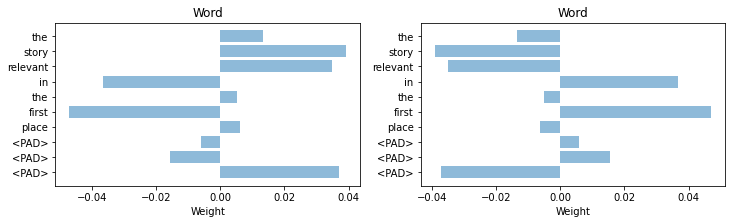

Experiment #1


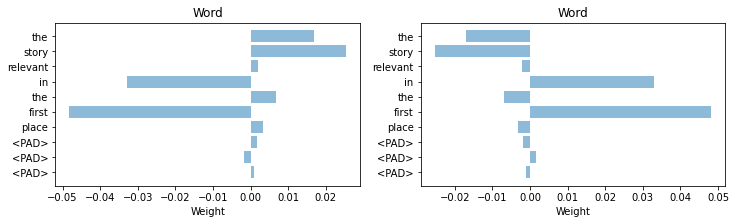

Experiment #2


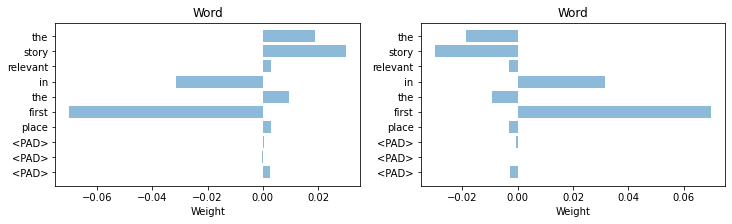

Experiment #3


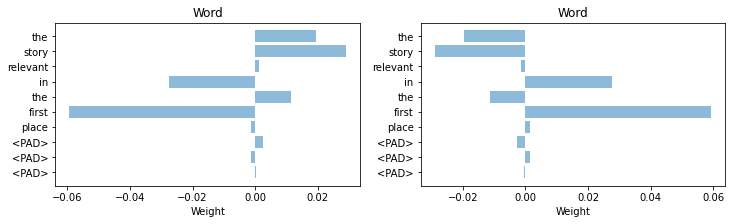

Experiment #4


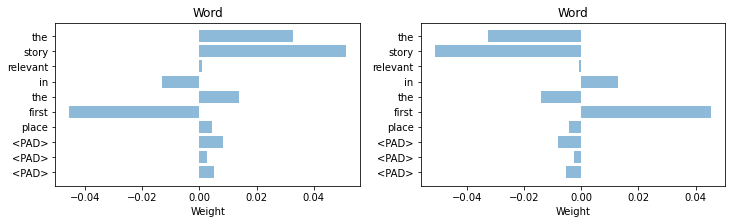

Experiment #5


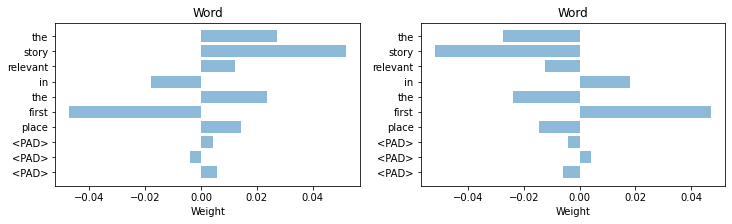

Experiment #6


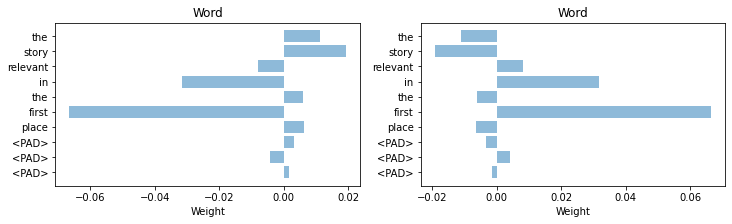

Experiment #7


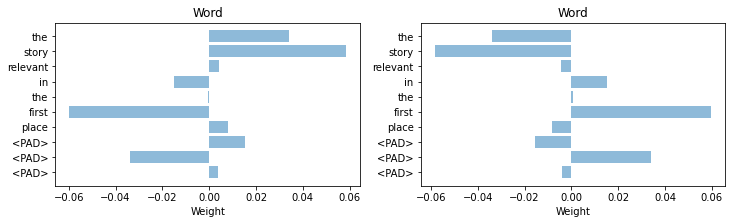

Experiment #8


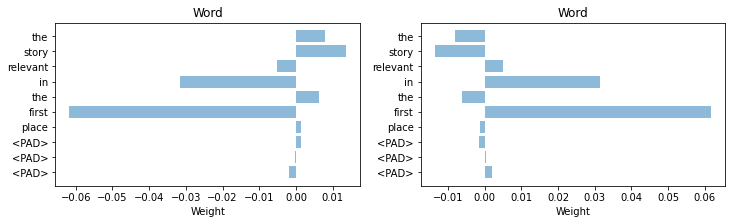

Experiment #9


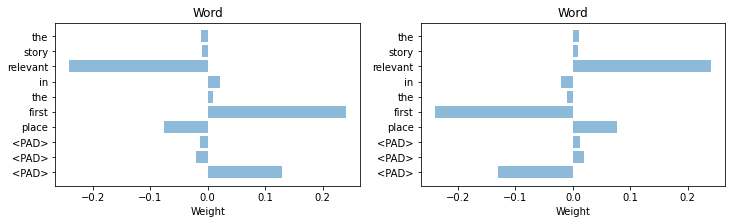


------------------------------------------------------------------



IndexError: list index out of range

In [53]:
idxs = [104275,101110]
# 1 positive 0 negative
y_trues = [0]

for ii in range(len(idxs)):
    idx = idxs[ii]
    y_true = y_trues[ii]

    input_path = 'X_tmp.npy'
    output_path = f'exps/exp{idx}'
    y_path = 'y_tmp.npy'


    exps = []
    for f in os.listdir(output_path):
        if os.path.isfile(os.path.join(output_path,f)) and not f.startswith('X') and not f.startswith('y') and not f.startswith('bg'):
            tmp = np.load(os.path.join(output_path,f))
            exps.append(tmp)

    sentence = text_train[idx]
    print('Input:',sentence)
    print('Class:',y_true)
    for jj,exs in enumerate(exps):
        print('Experiment #'+str(jj))
        fig, axs = plt.subplots(1,2)
        fig.set_size_inches(12,3)
        for i in range(2):
            ex = exs[i].reshape(50)
            print_exp(ex,text_train[idx],axs[i])
        plt.show()
            
    print()
    print('------------------------------------------------------------------')
    print()